In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from network import UNetMini
from dataset import DataFolder
from torch.utils.data import Subset
import torch.utils.data as data
from util import EarlyStopping, save_nets, save_predictions, load_best_weights,plot_images,weights_init_xavier
from apex.fp16_utils import *
from apex import amp, optimizers
from tqdm import tqdm

# Data Loading and parameters fixation

In [2]:
BATCH_SIZE=25
LR = 10e-3
PATIENCE = 3
MIN_DELTA = 10e-3
EPOCHS = 25
valid_BATCH_SIZE = 10
OPT_LEVEL = 'O2'

all_loader = data.DataLoader(
    dataset=DataFolder('dataset/all_images_256/', 'dataset/all_masks_256/', 'all'),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

Number of all images loaded: 790


In [3]:
from sklearn.model_selection import train_test_split


def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    return Subset(dataset, train_idx),Subset(dataset, val_idx)

dev,test = train_val_dataset(DataFolder('dataset/all_images_256/', 'dataset/all_masks_256/', 'all'))
train, valid = train_val_dataset(dev)


#We devide the dataset into train_test_split
train_loader = data.DataLoader(train)
valid_loader = data.DataLoader(valid)
test_loader = data.DataLoader(test)


Number of all images loaded: 790


In [4]:
print("Train size is {}".format(len(train_loader)))
print("Validation size is {}".format(len(valid_loader)))
print("Test size is {}".format(len(test_loader)))

Train size is 505
Validation size is 127
Test size is 158


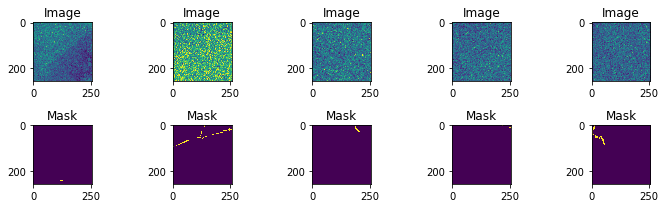

In [5]:
plot_images(train,5)

# Model definition
Considering the small dataset We used the miniUnet model defined in the Keras [Implementation](https://github.com/divamgupta/image-segmentation-keras/blob/275082c876186708a3801af5d60bda6f45a1af54/keras_segmentation/models/unet.py#L69) translated to Pytorch. We also used the nvidea [amp](https://github.com/NVIDIA/apex) for mixed model precision to have a faster training and to be able to work with bigger batches 

In [6]:

#Get the modele and pass it to cuda (We used colab with a GPU)
model = UNetMini(8).cuda() 

#params = {'params': }

#We used xavier initalisation
model.apply(weights_init_xavier)

#We used AdamW optimisation algorithm
solver = torch.optim.AdamW(model.parameters(),lr=1e-3)#optim.Adam(params, lr=LR)

#To go faster and with bigger batches, we used amp for mixed precision level 2
model, solver = amp.initialize(model, solver, opt_level=OPT_LEVEL)

#We used Cross Entropy But we could have used Soft Dice or Focal Loss maybe 
criterion = nn.CrossEntropyLoss()

#We use Early stopping to prevent overfiting
es = EarlyStopping(min_delta=MIN_DELTA, patience=PATIENCE)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


# Training 
**PS:** Occasionally seeing a message like “overflow detected, skipping step, reducing loss scale” is normal behavior with dynamic loss scaling, and it usually happens in the first few iterations because Amp begins by trying a high loss scale.

In [7]:
for epoch in tqdm(range(1, EPOCHS+1)):

    train_loss = []
    valid_loss = []

    for batch_idx, (img, mask, _) in enumerate(train_loader):

        solver.zero_grad()
        
        img = img.cuda()
        mask = mask.cuda()

        pred = model(img)
        loss = criterion(pred, mask)

        #loss.backward()

        with amp.scale_loss(loss, solver) as scaled_loss:
          scaled_loss.backward()
        solver.step()

        train_loss.append(loss.item())

    with torch.no_grad():
        for batch_idx, (img, mask, _) in enumerate(valid_loader):

            img = img.cuda()
            mask = mask.cuda()

            pred = model(img)
            loss = criterion(pred, mask)

            valid_loss.append(loss.item())

    print('[EPOCH {}/{}] Train Loss: {:.4f}; Valid Loss: {:.4f}'.format(
        epoch, EPOCHS, np.mean(train_loss), np.mean(valid_loss)
    ))

    flag, best, patience_epochs = es.step(torch.Tensor([np.mean(valid_loss)]))
    if flag:
        print('Early stopping criterion met')
        break
    else:
        if patience_epochs == 0:
            save_nets(model,amp,solver, 'model')
            print('Saving current best model')

        print('Current Valid loss: {:.4f}; Current best: {:.4f}; Patience : {}'.format(
            np.mean(valid_loss), best.item(), patience_epochs
        ))

print('Training done... start evaluation')

with torch.no_grad():
    valid_loss = []
    for batch_idx, (img, mask, _) in enumerate(valid_loader):

        model = load_best_weights(model,amp,solver,OPT_LEVEL,'model')

        img = img.cuda()
        mask = mask.cuda()

        pred = model(img)
        loss = criterion(pred, mask)

        valid_loss.append(loss.item())

        print('[validation loss per batch {}/{}] Eval Loss: {:.4f}'.format(
            batch_idx+1, len(valid_loader), loss.item()
        ))

print('Average validation loss: {:.4f}'.format(np.mean(valid_loss)))



  0%|          | 0/25 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


  4%|▍         | 1/25 [00:09<03:42,  9.26s/it]

[EPOCH 1/25] Train Loss: 0.1747; Valid Loss: 0.1220
Current Valid loss: 0.1220; Current best: 0.1220; Patience : 1


  8%|▊         | 2/25 [00:18<03:32,  9.26s/it]

[EPOCH 2/25] Train Loss: 0.1164; Valid Loss: 0.1106
Saving current best model
Current Valid loss: 0.1106; Current best: 0.1106; Patience : 0


 12%|█▏        | 3/25 [00:27<03:24,  9.28s/it]

[EPOCH 3/25] Train Loss: 0.1153; Valid Loss: 0.0972
Saving current best model
Current Valid loss: 0.0972; Current best: 0.0972; Patience : 0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


 16%|█▌        | 4/25 [00:37<03:15,  9.30s/it]

[EPOCH 4/25] Train Loss: 0.1124; Valid Loss: 0.0997
Current Valid loss: 0.0997; Current best: 0.0972; Patience : 1
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


 20%|██        | 5/25 [00:46<03:06,  9.31s/it]

[EPOCH 5/25] Train Loss: 0.1296; Valid Loss: 0.0983
Current Valid loss: 0.0983; Current best: 0.0972; Patience : 2
[EPOCH 6/25] Train Loss: 0.1086; Valid Loss: 0.0910
Early stopping criterion met
Training done... start evaluation
[validation loss per batch 1/127] Eval Loss: 0.0471
[validation loss per batch 2/127] Eval Loss: 0.0258
[validation loss per batch 3/127] Eval Loss: 0.1277
[validation loss per batch 4/127] Eval Loss: 0.0649
[validation loss per batch 5/127] Eval Loss: 0.1366
[validation loss per batch 6/127] Eval Loss: 0.0146
[validation loss per batch 7/127] Eval Loss: 0.0955
[validation loss per batch 8/127] Eval Loss: 0.0693
[validation loss per batch 9/127] Eval Loss: 0.0268
[validation loss per batch 10/127] Eval Loss: 0.1186
[validation loss per batch 11/127] Eval Loss: 0.0247
[validation loss per batch 12/127] Eval Loss: 0.0143
[validation loss per batch 13/127] Eval Loss: 0.1097
[validation loss per batch 14/127] Eval Loss: 0.0141
[validation loss per batch 15/127] Ev

# Running TEST

In [18]:
with torch.no_grad():
    all_loss = []
    for batch_idx, (img, mask, img_fns) in enumerate(all_loader):

        img = img.cuda()
        mask = mask.cuda()

        pred = model(img)
        loss = criterion(pred, mask)

        all_loss.append(loss.item())

        pred_mask = torch.argmax(F.softmax(pred, dim=1), dim=1)
        pred_mask = torch.chunk(pred_mask, chunks=1, dim=0)

        print('[PREDICT {}/{}] Loss: {:.4f}'.format(
            batch_idx+1, len(all_loader), loss.item()
        ))

print('FINAL PREDICT LOSS: {:.4f}'.format(np.mean(all_loss)))


[PREDICT 1/32] Loss: 0.0842
[PREDICT 2/32] Loss: 0.1852
[PREDICT 3/32] Loss: 0.1185
[PREDICT 4/32] Loss: 0.0802
[PREDICT 5/32] Loss: 0.0851
[PREDICT 6/32] Loss: 0.0807
[PREDICT 7/32] Loss: 0.0930
[PREDICT 8/32] Loss: 0.1213
[PREDICT 9/32] Loss: 0.0990
[PREDICT 10/32] Loss: 0.1135
[PREDICT 11/32] Loss: 0.1326
[PREDICT 12/32] Loss: 0.1152
[PREDICT 13/32] Loss: 0.0885
[PREDICT 14/32] Loss: 0.1138
[PREDICT 15/32] Loss: 0.1083
[PREDICT 16/32] Loss: 0.1157
[PREDICT 17/32] Loss: 0.1027
[PREDICT 18/32] Loss: 0.1284
[PREDICT 19/32] Loss: 0.0846
[PREDICT 20/32] Loss: 0.1148
[PREDICT 21/32] Loss: 0.0775
[PREDICT 22/32] Loss: 0.1116
[PREDICT 23/32] Loss: 0.1258
[PREDICT 24/32] Loss: 0.1005
[PREDICT 25/32] Loss: 0.1672
[PREDICT 26/32] Loss: 0.1298
[PREDICT 27/32] Loss: 0.0958
[PREDICT 28/32] Loss: 0.0892
[PREDICT 29/32] Loss: 0.1239
[PREDICT 30/32] Loss: 0.1291
[PREDICT 31/32] Loss: 0.1188
[PREDICT 32/32] Loss: 0.0902
FINAL PREDICT LOSS: 0.1102


# PS 

*   The results are quite good, with this relatevely small model.
*   The dataset is quite small, and we were limiter on compute power, a more intersting approach would be to do a cross validation using Ligheting or maybe wrapping the model in skorch.  

